# [Computational Social Science] Project 4: Unsupervised Learning

Group Number: 2

Group Members: Alagia Cirolia, Christina Misunas, Michi Kakebayashi

# Part 1: Introduction (from PDF)

In this project, you will use unsupervised learning and deep learning techniques
to explore a large dataset and prepare it for prediction. You will examine data
taken from the National Health and Nutrition Examination Survey (NHANES).
NHANES is a nationally representative survey that combines interviews with
medical examinations to collect about 200 variables about 5000 people each
year. The data you are working with is drawn from the 2013-2014 version of
this study.

You have been tasked with using this dataset to study social determinants
of public health outcomes. NHANES contains data about social determinants
such as family income, education, occupation etc., and health outcomes related
to conditions like diabetes, heart disease, osteoporosis, etc. Some of these data
are collected via survey, and others from medical exams.

You will specifically
try to predict the variable, “HSD010” which corresponds to the question:
“Would you say your/SP’s health in general is:
* a. Excellent
* b. Very good
* c. Good
* d. Fair
* e. Poor

# Part 2: Data Description and Preprocessing (from PDF)

The NHANES data has already been combined and preprocessed for you. The
overall dataset, “nhanes.csv” was combined from datasets covering demographics, diet, lab results, examination results, and a questionnaire. There was significant missingness in some of these datasets, so they were cleaned for the purposes
of this project.
1

Your ultimate goal is to predict individuals’ self-reported health condition
(’HSD010’). Respondents can say they are feeling “excellent,” “very good,”
“good,” “fair,” or “poor.” You may either predict HSD010’s original five categories, or convert it to a binary where “excellent,” “very good,” and “good” are
“good” and “fair” and “poor” are “poor” health.

Before turning to prediction however, you you should first explore and summarize the data with some unsupervised learning techniques. Specifically, you
will be solving two problems. First, you will tackle the curse of dimensionality- meaning you have many features in this dataset that can rapidly increase the
overall complexity of a model. Second, you will address the issue of grouping
different observations to aid in downstream classification. You might think of
these unsupervised learning procedures as minimizing the complexity introduced
by your columns and the noise introduced by your rows.

Consider the following boxplots that visualize the relationship between the
ratio of family income to the federal poverty line and self-reported health condition:
Figure 1: Boxplot of Income-Poverty Ratio and Health Condition.
There are some clear patterns here - reported health condition declines the
closer a family is to the poverty line. However, lots of features in the dataset
probably correlate with both family income and health condition. One of your
tasks will be to simplify the nearly 250 features in the dataset into fewer features
so you better predict self-reported health condition.

It’s also possible that while income strongly correlates with self-reported
health condition, it does not necessarily correlate with actual health condition.
Consider Figure 3 which shows the relationship between body mass index (BMI)
and the family income-poverty line ratio. BMI is a strong predictor of other
health conditions like diabetes, heart disease, obesity, etc. and yet does not
have a clear relationship with family income. Figuring out how to automatically group data points together to better predict health condition might be better
than making judgments about these proxies.

### Data Description and Preprocessing (from notebook)

For this project, you will explore data from the National Health and Nutrition Examination Survey. NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. HSD010 asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split

# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


### Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.


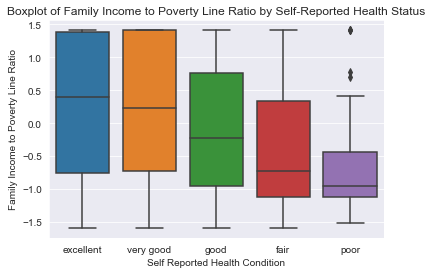

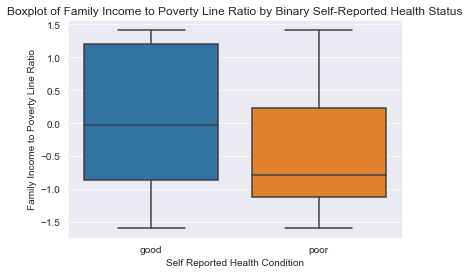

In [2]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy.

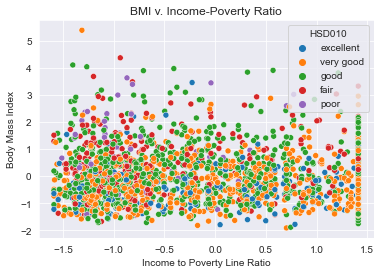

In [3]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [4]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

# Part 3: Principal Component Analysis

### First, we chose the number of components.

In [9]:
nhanes_scaled.shape[1]
### Total features: 241

241

In [10]:
### First, we chose the number of components
### Reduce 241 to 120 

from sklearn.decomposition import PCA
pca = PCA(n_components= .9)
principalComponents_nhanes = pca.fit_transform(nhanes_scaled)

pca_df = pd.DataFrame(data = principalComponents_nhanes)
pca_df.head()


,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,9.527811,-0.816224,-1.867091,-2.109908,-3.929375,-0.185332,-3.845128,-2.934825,1.514138,0.682613,...,0.579063,0.249073,0.608720,-0.099911,1.311298,-0.496083,0.353020,-0.883487,0.555911,0.034937
1,-5.838339,-3.692573,3.805749,-1.029680,0.394578,1.593149,2.711101,-0.740594,0.384751,-2.406291,...,-0.314759,1.301043,0.811930,0.602309,-1.357086,-0.337181,-1.081450,-1.274075,-0.345200,1.568245
2,-0.719454,-2.573200,0.907904,-4.755854,-1.798847,0.863651,-1.024494,0.633063,0.542111,0.449352,...,-0.261586,0.921092,-0.022817,-0.295372,-0.000724,-0.353524,0.463514,-0.301398,-0.545790,-0.446302
3,3.533627,-2.576982,-3.249124,-0.405426,3.999037,1.444511,-1.182086,0.326650,-4.151250,-1.245445,...,0.155250,-0.013115,-0.164206,-0.855449,-1.107724,0.028349,-0.284558,-1.422783,-0.742018,-0.151057
4,-6.872094,-4.194241,0.886831,-0.848954,-0.524848,0.073034,0.843855,0.987843,0.556969,-0.045043,...,-0.436904,-0.375095,0.488059,-0.038724,-0.672824,-0.296166,0.563770,-0.686886,-0.880388,0.249445


### Then, we used a barplot to show the variation explained by each component

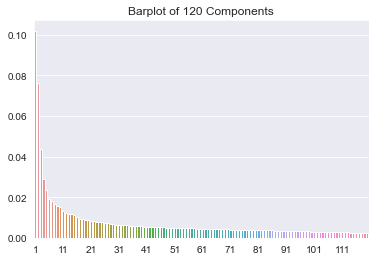

In [11]:

# Barplot
sns.barplot(x = np.arange(1, pca_df.shape[1]+1, step =1), y =  pca.explained_variance_ratio_)
plt.xticks(np.arange(0, pca_df.shape[1], step=10))
plt.title('Barplot of 120 Components');

*Principal components explain a part of the variance.* Here, there is a total of 120 variables using a threshold of 90% variance. In some situations, there are other methods of determining the threshold for keeping variables in a PCA model, such as using eigenvalues. More conservative thresholds, as in between 95-99%, may also be used. *Appropriate threshold is not pre-determined and depends case-by-case.* In this case, we erred on the side of reducing complexity. *That is, the higher the threshold, the more principal components we need but in this case where we explore social determinants of public health outcomes, it is useful to limit for the sake of discussion.* 

In visualizing this model with a barplot, around 31 variables seem to capture the majority of the variables before a plateau in reducing variance with each additional variable. While 31 variables will capture less than 90% of the variance, it still captures variance while balancing complexity. We will move forward with this smaller PCA model for analysis. In the case of interpretability of health data, 31 variables may be more feasible for conducting more targeted research and generating public health interventions overall. It would not be appropriate, however, for creating an algorithm to be explicitly employed at face value as a public health tool.

### This helped us to identify the number of components to use in fitting our supervised learning model

In visualizing this model with a barplot, around 31 variables seem to capture the majority of the variables before a plateau in reducing variance with each additional variable. While 31 variables will capture less than 90% of the variance, it still captures variance while balancing complexity. We will move forward with this smaller PCA model for analysis. In the case of interpretability of health data, 31 variables may be more feasible for conducting more targeted research and generating public health interventions overall. It would not be appropriate, however, for creating an algorithm to be explicitly employed at face value as a public health tool.

Based on the plot of the variance accounted for by each additional feature, additional features past 31 contribute less and less to explaining variation. Therefore, we would use this visual to conclude that 31 variables (or less) would be useful for a supervised method. In fact, the first 15 variables seem most important, but 31 captures the majority of variables before the variance plateau.

*PCA reduces the dimention of data. This is useful for gaining insight about patterns in data (trends, relationships, biases, groups), discovering errors/issues with data (clean data), figuring out what questions to ask about data, determining how to model data. If the raw data is complex and high-dimentional as it is with this data, dimensionality reduction describes the data using a simpler, more compact representation. It may also display interesting pattern of the data with more clarity. Here our aim is understand the pattern and how to make out of the complex data that does not seem to show patterns.*

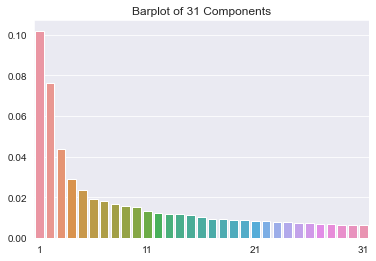

In [12]:
pca_2 = PCA(n_components= 31)
principalComponents_nhanes_2 = pca_2.fit_transform(nhanes_scaled)

pca_df_2 = pd.DataFrame(data = principalComponents_nhanes_2)
pca_df_2.head()

sns.barplot(x = np.arange(1, pca_df_2.shape[1]+1, step =1), y =  pca_2.explained_variance_ratio_)
plt.xticks(np.arange(0, pca_df_2.shape[1], step=10))
plt.title('Barplot of 31 Components');


In [13]:
### Name columns for graphing
pca_df_2comps = pd.DataFrame(data = pca_df_2)
pca_df_2comps.columns = columns = ['principle components 1', 'principle components 2', 'principle components 3','principle components 4','principle components 5','principle components 6','principle components 7','principle components 8','principle components 9','principle components 10','principle components 11','principle components 12','principle components 13','principle components 14','principle components 15','principle components 16','principle components 17','principle components 18','principle components 19','principle components 20','principle components 21','principle components 22','principle components 23','principle components 24','principle components 25','principle components 26','principle components 27','principle components 28','principle components 29','principle components 30','principle components 31']
pca_df_2comps.head()
#I'm sure there was a more elegant way to rename the columns but we couldn't think of one faster than we could actually write the list


,principle components 1,principle components 2,principle components 3,principle components 4,principle components 5,principle components 6,principle components 7,principle components 8,principle components 9,principle components 10,...,principle components 22,principle components 23,principle components 24,principle components 25,principle components 26,principle components 27,principle components 28,principle components 29,principle components 30,principle components 31
0,9.527813,-0.816274,-1.867180,-2.109938,-3.931603,-0.167638,-3.839548,-2.904725,1.496791,0.676842,...,-0.739489,0.452568,0.559665,-1.320606,-0.739324,-0.477757,-0.569570,0.961776,-0.200192,1.194892
1,-5.838310,-3.692464,3.805890,-1.029378,0.395261,1.564668,2.709296,-0.784389,0.418742,-2.362793,...,-0.295906,2.185752,3.891372,0.412746,-1.216904,-0.601377,0.858517,-0.795965,1.107761,-2.245833
2,-0.719464,-2.573239,0.908027,-4.755576,-1.800379,0.867004,-1.014400,0.632789,0.535350,0.461875,...,-1.353990,-0.680778,-0.224552,0.505178,0.660267,0.336122,-2.054268,0.258160,0.033123,-0.321349
3,3.533636,-2.576937,-3.249426,-0.405615,3.999275,1.445106,-1.191282,0.336901,-4.156915,-1.276978,...,0.886335,-1.056210,1.008634,-0.667051,-1.650508,-1.067047,-0.138498,-0.448702,-1.872973,-0.392146
4,-6.872099,-4.194252,0.886540,-0.848339,-0.525602,0.064245,0.848540,0.992534,0.529685,-0.082210,...,-0.201466,-0.316831,-2.621744,0.566429,-0.301400,2.497118,-0.884886,2.567222,-0.410276,0.438796


In [14]:
### Need to add binary outcome back in to plot
pca_df_2comps['HSD010_binary'] = hsd010
pca_df_2comps['HSD010_binary'] = pca_df_2comps['HSD010_binary'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
### We originally tried to use pca_df_2comps['HSD010_binary'] = hsd010_binary but that didn't work
pca_df_2comps['HSD010_binary']

0       good
1       good
2       good
3       good
4       good
        ... 
2059    good
2060    good
2061    poor
2062    good
2063    good
Name: HSD010_binary, Length: 2064, dtype: object

### As a final step, we plotted a 2D scatterplot of the first two components.

<Figure size 432x288 with 0 Axes>

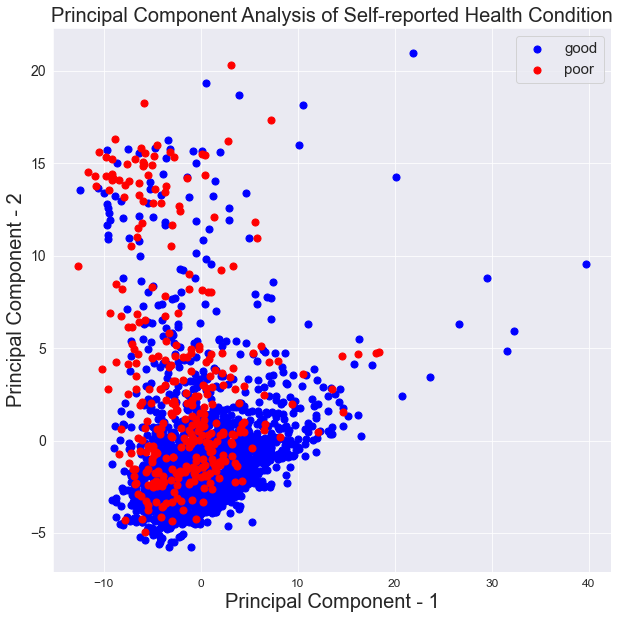

In [17]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Self-reported Health Condition",fontsize=20)
targets = ['good', 'poor']
colors = ['b', 'r']

for target, color in zip(targets,colors):
    indicesToKeep = pca_df_2comps['HSD010_binary'] == target
    plt.scatter(pca_df_2comps.loc[indicesToKeep, 'principle components 1']
               , pca_df_2comps.loc[indicesToKeep, 'principle components 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})
plt.show()

# Part 4: Clustering



### K-Means was chosen as our clustering algorithm.

This algorithm clusters data by trying to separate samples in n groups of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. It requires the number of clusters to be specified. We chose this algorithm because it scales well to large numbers of samples and has been used across a large range of application areas in many different fields.

#### As a first step, we cluster the data.

In [18]:
np.random.seed(10)

X = nhanes_scaled
X

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ033,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,-0.680203,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,-0.680203,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83694,0.0,0.261930,0.0,0.324834,-0.481375,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.998146,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,1.087115,-0.683338,0.612440
83696,0.0,0.495138,0.0,0.324834,1.093063,0.634362,-0.194202,-0.057306,0.128246,-0.189513,...,0.998146,0.383802,0.246091,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812
83704,0.0,0.728346,0.0,-3.078499,0.305844,-0.268620,-0.194202,-0.057306,0.128246,0.080373,...,-0.680203,0.383802,2.031441,2.065262,1.125008,0.0,0.480384,-0.919866,-0.683338,-1.632812


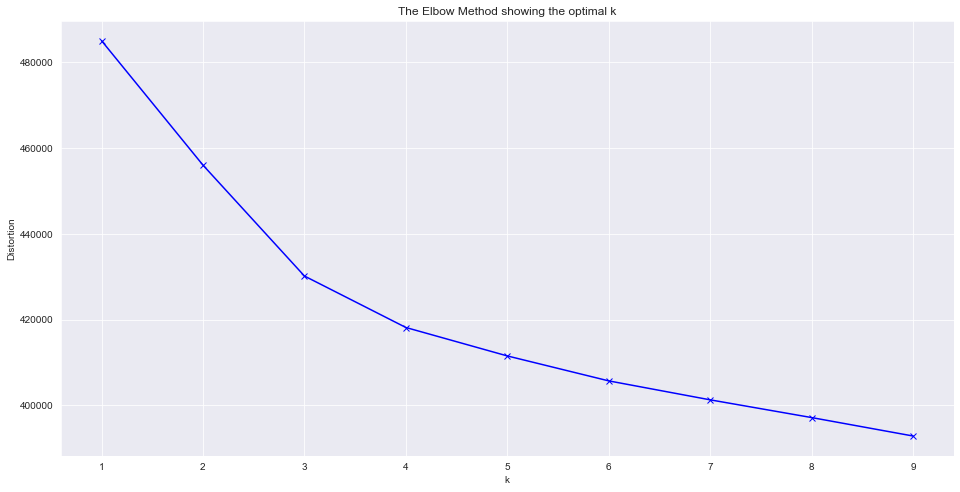

In [19]:
#### We used the elbow method to identify 5 potential clusters within the data.

distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [20]:
kmeans = KMeans(n_clusters=5,
               max_iter=300 
               ).fit(X)

print("Centers")
print(kmeans.cluster_centers_)
print()

print("Labels")
print(kmeans.labels_)
print()

for point, label in zip(nhanes_scaled, kmeans.labels_):
    print("Coordinates:", point, "Label:", label)

Centers
[[ 0.          0.04039886  0.         ... -0.0910842  -0.20456818
   0.33461065]
 [ 0.          0.01745877  0.         ... -0.0076022  -0.08566547
  -0.02541534]
 [ 0.          0.03164354  0.         ...  0.00679083 -0.0657138
  -1.27857253]
 [ 0.         -0.0940195   0.         ...  0.29488534  0.33353994
   0.61244043]
 [ 0.         -0.07735045  0.         ...  0.04200478  0.34551546
   0.54001293]]

Labels
[1 2 2 ... 2 1 0]

Coordinates: DR1DRSTZ Label: 1
Coordinates: DR1EXMER Label: 2
Coordinates: DRABF Label: 2
Coordinates: DRDINT Label: 0
Coordinates: DR1DBIH Label: 2
Coordinates: DR1DAY Label: 1
Coordinates: DR1LANG Label: 2
Coordinates: DR1MNRSP Label: 4
Coordinates: DR1HELPD Label: 0
Coordinates: DBQ095Z Label: 0
Coordinates: DRQSPREP Label: 0
Coordinates: DR1STY Label: 4
Coordinates: DRQSDIET Label: 0
Coordinates: DR1TNUMF Label: 4
Coordinates: DR1TKCAL Label: 0
Coordinates: DR1TPROT Label: 3
Coordinates: DR1TCARB Label: 3
Coordinates: DR1TSUGR Label: 0
Coordinates: D

#### We plotted our clusters on top of BMI v. Income Poverty Ratio Plot.

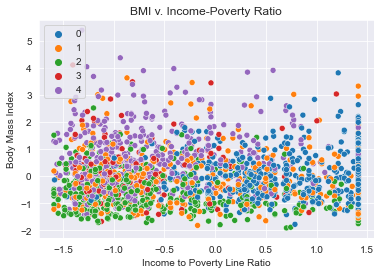

In [21]:
ax2 = sns.scatterplot(x = 'INDFMPIR', y = 'BMXBMI', hue = kmeans.labels_ , palette = "tab10", data = X)
ax2.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax2.set_title("BMI v. Income-Poverty Ratio")
plt.show()

#### We then retrained the clustering algorithm on PCA components. As a final step, we plotted the clusters on our 2D scatterplot.

In [22]:
nhanes_scaled_v2 = pca_df_2comps.drop(['HSD010_binary'], axis = 1)
print(nhanes_scaled_v2)

      principle components 1  principle components 2  principle components 3  \
0                   9.527813               -0.816274               -1.867180   
1                  -5.838310               -3.692464                3.805890   
2                  -0.719464               -2.573239                0.908027   
3                   3.533636               -2.576937               -3.249426   
4                  -6.872099               -4.194252                0.886540   
...                      ...                     ...                     ...   
2059                2.643320               -1.689349               -0.702738   
2060                1.037907               -0.118060                5.555954   
2061                1.130244               -0.970379                3.415306   
2062                7.145081               -0.376760                1.753127   
2063                0.050871               -0.967305               -4.447508   

      principle components 4  principle

In [24]:
print("Centers")
print(kmeans.cluster_centers_)
print()

print("Labels")
print(kmeans.labels_)
print()

for point, label in zip(nhanes_scaled_v2, kmeans.labels_):
    print("Coordinates:", point, "Label:", label)

nhanes_scaled_v2["Labels"] = kmeans.labels_

nhanes_scaled_v2["Labels"] = nhanes_scaled_v2["Labels"].replace(
    [0, 1, 2, 3, 4], ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'])

Centers
[[ 0.          0.04039886  0.         ... -0.0910842  -0.20456818
   0.33461065]
 [ 0.          0.01745877  0.         ... -0.0076022  -0.08566547
  -0.02541534]
 [ 0.          0.03164354  0.         ...  0.00679083 -0.0657138
  -1.27857253]
 [ 0.         -0.0940195   0.         ...  0.29488534  0.33353994
   0.61244043]
 [ 0.         -0.07735045  0.         ...  0.04200478  0.34551546
   0.54001293]]

Labels
[1 2 2 ... 2 1 0]

Coordinates: principle components 1 Label: 1
Coordinates: principle components 2 Label: 2
Coordinates: principle components 3 Label: 2
Coordinates: principle components 4 Label: 0
Coordinates: principle components 5 Label: 2
Coordinates: principle components 6 Label: 1
Coordinates: principle components 7 Label: 2
Coordinates: principle components 8 Label: 4
Coordinates: principle components 9 Label: 0
Coordinates: principle components 10 Label: 0
Coordinates: principle components 11 Label: 0
Coordinates: principle components 12 Label: 4
Coordinates: prin

<Figure size 432x288 with 0 Axes>

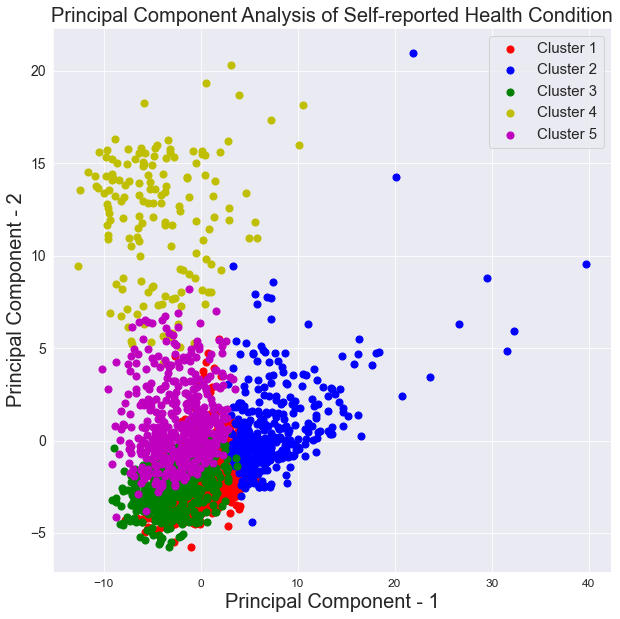

In [25]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Self-reported Health Condition",fontsize=20)
targets = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5']
colors = ['r', 'b', 'g', 'y', 'm']

for target, color in zip(targets,colors):
    indicesToKeep2 = nhanes_scaled_v2["Labels"] == target
    plt.scatter(nhanes_scaled_v2.loc[indicesToKeep2, 'principle components 1']
               , nhanes_scaled_v2.loc[indicesToKeep2, 'principle components 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})
plt.show()


# Part 5: Neural Network


Now we are ready to predict! Do the following:
* Choose either HSD010 or HSD010 binary as your target outcome.
* Train a neural network using the original features. Much of the code to
train a basic neural net has been set up for you, but you will need to fill
in a couple of missing pieces.
* Train a neural network using only your PCA components as features.
* Train a neural network using your PCA components and the predicted
class membership from your clustering algorithm as features.

* Compare and contrast how well each algorithm did. Which featurization
technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

In [ ]:
import keras
from keras.utils import np_utils

In [27]:
#### We choose HSD010 binary as our target outcome."""

hsd010_binary = hsd010.replace([1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor'])
y = hsd010_binary
y = y.replace(["good", "poor"], [0,1]) # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already ### Alagia: binary b/c easier, separate outcome variable I made above
X = nhanes_scaled 
X= X.astype(int)
print(X.shape)
num_features = 241

(2064, 241)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

#### First, we trained a neural network using all original features.

In [ ]:

num_classes = 2

# convert class vectors to binary class matrices
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

In [ ]:
model = Sequential()


model.add(
    Dense(num_features, input_dim=num_features, kernel_initializer='normal', activation='relu')
)

model.add(
    Dense(num_classes, kernel_initializer='normal', activation='softmax')
)

## Add any additional layers you wish here

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)

#### As a second step, we trained a neural network using only our PCA components as features.

In [47]:
## The data we want to use here is called pca_df_2comps because it has the components and the outcome
X_PC=pca_df_2comps.drop(['HSD010_binary'], axis = 1) #drop binary outcome here
y_pc=y #stays the stame since stored in separate variable- copy
X_PC= X_PC.astype(int)
print(X_PC.shape)
num_features_pc = 31

(2064, 31)


In [ ]:
X_train_pc, X_test_pc, y_train_pc, y_test_pc = train_test_split(X_PC, y_pc, test_size = .25, random_state = 10)

In [ ]:
num_classes_pc = 2
# convert class vectors to binary class matrices
y_train_pc = np_utils.to_categorical(y_train_pc, num_classes)
y_test_pc = np_utils.to_categorical(y_test_pc, num_classes)

In [ ]:
model = Sequential()

model.add(
    Dense(num_features_pc, input_dim=num_features_pc, kernel_initializer='normal', activation='relu')
)
model.add(
    Dense(num_classes_pc, kernel_initializer='normal', activation='softmax')
)
## Add any additional layers you wish here

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_pc, y_train_pc, validation_data=(X_test_pc, y_test_pc), epochs=10, batch_size=200, verbose=2)

#### Finally, we trained a neural network using our PCA components and the predicted class membership from our clustering algorithm as features.

In [49]:
###  The data we want to use here is called nhanes_scaled_v2 because it has the components and the clusters, but first we need to add binary outcome back in to plot. 
X_cluster = nhanes_scaled_v2
X_cluster = X_cluster.replace(['Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'], [1,2,3,4,5])
y_cluster = y

X_cluster= X_cluster.astype(int)
print(X_cluster.shape)
num_features_cluster = 32

(2064, 32)


In [ ]:
X_train_cluster, X_test_cluster, y_train_cluster, y_test_cluster = train_test_split(X_cluster, y_cluster, test_size = .25, random_state = 10)

In [ ]:
# convert class vectors to binary class matrices
num_classes_cluster = 2
y_train_cluster = np_utils.to_categorical(y_train_cluster, num_classes)
y_test_cluster = np_utils.to_categorical(y_test_cluster, num_classes)

In [ ]:
model = Sequential()

model.add(
    Dense(num_features_cluster, input_dim=num_features_cluster, kernel_initializer='normal', activation='relu')
)

model.add(
    Dense(num_classes_cluster, kernel_initializer='normal', activation='softmax')
)
## Add any additional layers you wish here

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X_train_cluster, y_train_cluster, validation_data=(X_test_cluster, y_test_cluster), epochs=10, batch_size=200, verbose=2)

#### Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?


The neural network did not seem to show great improvement in its predictions over PCA or clustering. Given that the neural network is also less transparent, in order to use unsupervised methods in conjunction with supervised methods to guide public health research, PCA or clustering provided more transparent and better results. There are opportunities for PCA and clustering to work in conjunction that is still transparent, and can be more easily adjusted to respond to different needs or requirements around accuracy/thresholds for multiple iterations towards addressing research questions. 

Clustering overall seems like the most useful and transparent tactic in exploring self-rated health outcomes. Principle component analysis still left us with too many variables for clear interpretation. Additionally, if the goal of this research is improving health by potentially changing health-influencing variables, we might be more interested in using clustering to identify which "clusters" would be targets for an intervention to change their "cluster" membership.


# 6. Discussion Questions

**Question 1:**
In your own words, what is the difference between PCA and clustering?

PCA draws on input variables to create a new set of principal component variables that more effeciently summarize the data. It essentially reduces the data into fewer components (or fewer features) based on covariance/similarity of the total set of features.
Clustering divides data into groups based on feature dissimilarity (their relative distance).

**Question 2:**
Did you notice any advantages to combining PCA and clustering? If so,
what do you think they were? If not, why do you think you didn’t see any
gains from this combination?

It is useful to combine PCA and clustering in the sense that both techniques can help us reduce the dimensions of our data while grouping similar points together. Using PCA before clustering can also help to improve the performance of clustering by preprocessing and removing noise from big data. If certain variables within the data are highly correlated, PCA can be used to extract key components before conducting the clustering analysis.

**Question 3:**
How can unsupervised techniques help with downstream supervised learning tasks when working with “big data?”

When working with big data, unsupervised learning techniques can help with downstream supervised learning tasks in the following ways:
1) Unsupervised learning can help make big data more usable. It helps to process/remove any noise in big data before it is used in a supervised learning model, ultimate leading to a better performance.
2) Unsupervised learning techniques like PCA can help extract key components from big data that can later be used in the supervised learning models. This is a data-driven parallel to theoretically-driven feature selection in supervised models, where instead unsupervised methods use the data to identify these features.
3) Unsupervised learning techniques like Clustering can help to identify patterns/groupings/relationships in the big data that can later be used to guide our development of the supervised learning model. It could also confirm theoretical notions about the data or problem.